# IE5561 Project1: Online News Popularity

## Author: Weiqi Wang, Shaoliang Ni
## Date: 2/26/2020

## 1 Loading libraries and dataset

In [83]:
# load libraries
library(tidyverse)
library(ROCR)
library(pROC) 
library(caret) 
library(rpart)
library(rattle)
library(xgboost)
library(tibble)
library(dplyr)
library(randomForest)
require(varhandle)
library(reshape)
require(glmnet)
library(pls)

In [2]:
# load the dataset
news.data <- read.csv("./data/OnlineNewsPopularity/OnlineNewsPopularity.csv")

## 2 Data Description and Manipulation

In [3]:
# Omiting NA values
news.data <- na.omit(news.data)

Description by looking into its basic statistics

In [4]:
summary(news.data)

                                                             url       
 http://mashable.com/2013/01/07/amazon-instant-video-browser/  :    1  
 http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/   :    1  
 http://mashable.com/2013/01/07/apple-40-billion-app-downloads/:    1  
 http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/      :    1  
 http://mashable.com/2013/01/07/att-u-verse-apps/              :    1  
 http://mashable.com/2013/01/07/beewi-smart-toys/              :    1  
 (Other)                                                       :39638  
   timedelta     n_tokens_title n_tokens_content n_unique_tokens   
 Min.   :  8.0   Min.   : 2.0   Min.   :   0.0   Min.   :  0.0000  
 1st Qu.:164.0   1st Qu.: 9.0   1st Qu.: 246.0   1st Qu.:  0.4709  
 Median :339.0   Median :10.0   Median : 409.0   Median :  0.5392  
 Mean   :354.5   Mean   :10.4   Mean   : 546.5   Mean   :  0.5482  
 3rd Qu.:542.0   3rd Qu.:12.0   3rd Qu.: 716.0   3rd Qu.:  0.6087  
 Max.   :731.0  

In [5]:
# Getting data types of variables
str(news.data)

'data.frame':	39644 obs. of  61 variables:
 $ url                          : Factor w/ 39644 levels "http://mashable.com/2013/01/07/amazon-instant-video-browser/",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ timedelta                    : num  731 731 731 731 731 731 731 731 731 731 ...
 $ n_tokens_title               : num  12 9 9 9 13 10 8 12 11 10 ...
 $ n_tokens_content             : num  219 255 211 531 1072 ...
 $ n_unique_tokens              : num  0.664 0.605 0.575 0.504 0.416 ...
 $ n_non_stop_words             : num  1 1 1 1 1 ...
 $ n_non_stop_unique_tokens     : num  0.815 0.792 0.664 0.666 0.541 ...
 $ num_hrefs                    : num  4 3 3 9 19 2 21 20 2 4 ...
 $ num_self_hrefs               : num  2 1 1 0 19 2 20 20 0 1 ...
 $ num_imgs                     : num  1 1 1 1 20 0 20 20 0 1 ...
 $ num_videos                   : num  0 0 0 0 0 0 0 0 0 1 ...
 $ average_token_length         : num  4.68 4.91 4.39 4.4 4.68 ...
 $ num_keywords                 : num  5 4 6 7 7 9 10 9 7 5 ...
 

### Answering some business questions
Next, we explored the data set by manipulating and visualizing data, and answer some business questions.

#### Which is the most popular news channel?

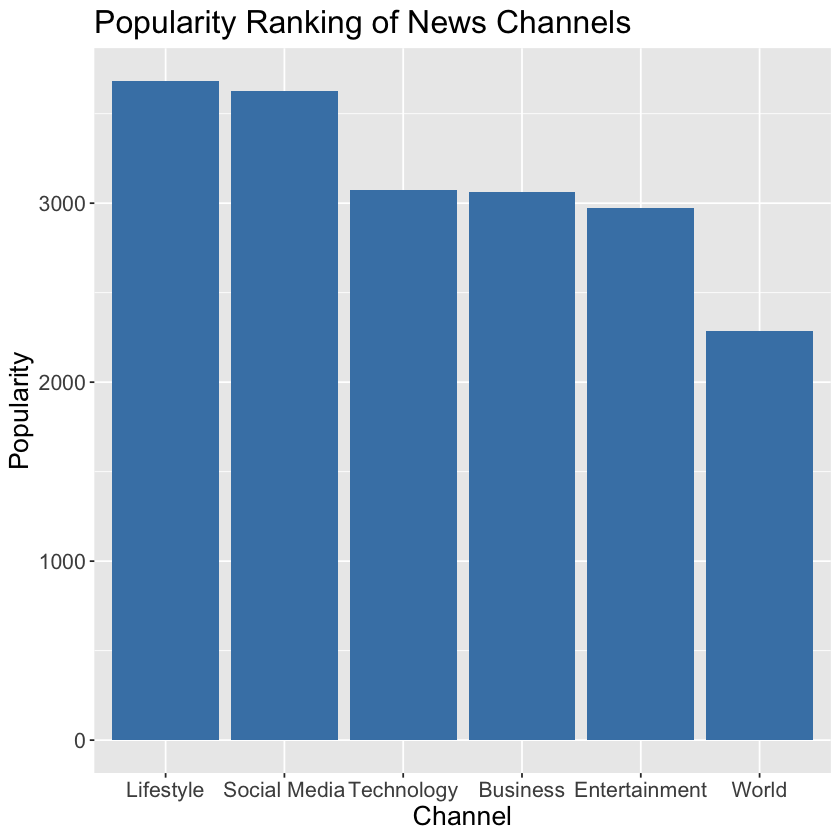

In [121]:
# making a dataframe for news channel
df.channel <- select(news.data, c(14:19, 61))

# for the same news channel, calculate its avg shares
df.channel.sum <- summarise(df.channel,
          Lifestyle = sum(shares[which(data_channel_is_lifestyle==1)])/sum(data_channel_is_lifestyle),
          Entertainment = sum(shares[which(data_channel_is_entertainment==1)])/sum(data_channel_is_entertainment),
          Business = sum(shares[which(data_channel_is_bus==1)])/sum(data_channel_is_bus),
          Social_Media = sum(shares[which(data_channel_is_socmed==1)])/sum(data_channel_is_socmed),
          Technology = sum(shares[which(data_channel_is_tech==1)])/sum(data_channel_is_tech),
          World = sum(shares[which(data_channel_is_world==1)])/sum(data_channel_is_world))
popularity <- as.numeric(df.channel.sum[1,])
channel <- c("Lifestyle", "Entertainment", "Business", "Social Media", "Technology", "World")
df.channel.sum <- data.frame(cbind(channel, popularity))
df.channel.sum$popularity <- unfactor(df.channel.sum$popularity)

# setting the axises font size
theme_update(text = element_text(size=16, angle = 0, hjust = 0.5))

ggplot(df.channel.sum, aes(x = reorder(channel, - popularity), y = popularity)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Popularity Ranking of News Channels", x = "Channel", y = "Popularity")

Hence, the most popular news channel is lifestyle.

#### What is the best timing to publish a news article in a week?

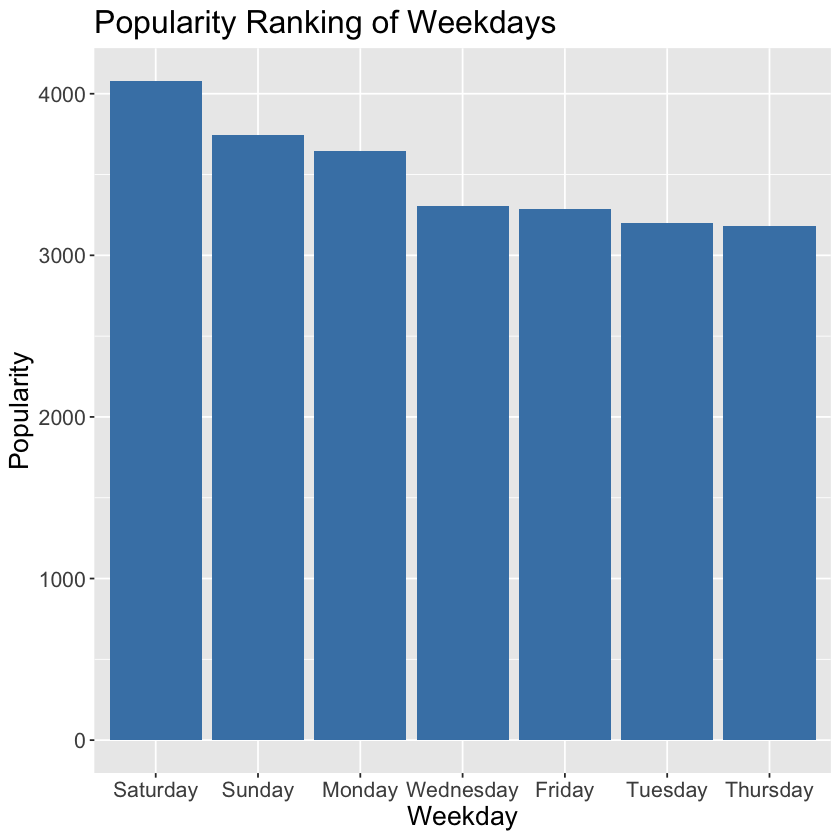

In [122]:
# making a dataframe for weekday
df.weekday <- select(news.data, c(32:38, 61))

# for the same weekday, calculate its avg shares
df.weekday.sum <- summarise(df.weekday,
          Monday = sum(shares[which(weekday_is_monday==1)])/sum(weekday_is_monday),
          Tuesday = sum(shares[which(weekday_is_tuesday==1)])/sum(weekday_is_tuesday),
          Wednesday = sum(shares[which(weekday_is_wednesday==1)])/sum(weekday_is_wednesday),
          Thursday = sum(shares[which(weekday_is_thursday==1)])/sum(weekday_is_thursday),
          Friday = sum(shares[which(weekday_is_friday==1)])/sum(weekday_is_friday),
          Saturdat = sum(shares[which(weekday_is_saturday==1)])/sum(weekday_is_saturday),
          Sunday = sum(shares[which(weekday_is_sunday==1)])/sum(weekday_is_sunday))
popularity <- as.numeric(df.weekday.sum[1,])
weekday <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
df.weekday.sum <- data.frame(cbind(weekday, popularity))
df.weekday.sum$popularity <- unfactor(df.weekday.sum$popularity)

ggplot(df.weekday.sum, aes(x = reorder(weekday, - popularity), y = popularity)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Popularity Ranking of Weekdays", x = "Weekday", y = "Popularity")

The best timing to publish a news article in a week is Saturday.

#### Using more positive words or using more negative words?

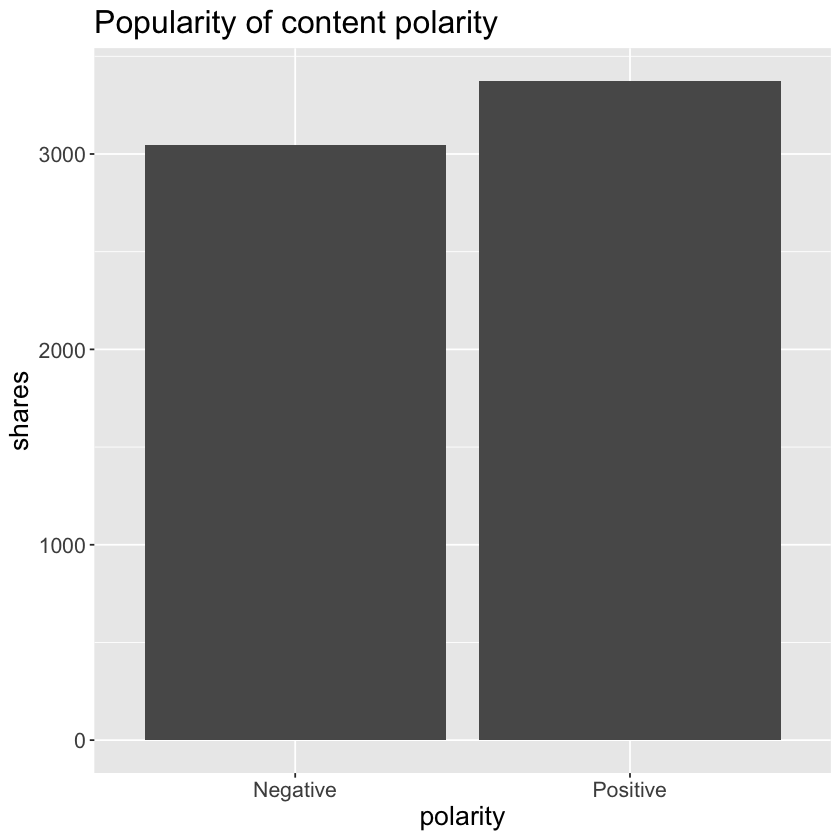

In [123]:
# making a dataframe for word polarity
df.polarity.word <- select(news.data, c(49:50, 61))

df.polarity.word$polarity <- NA
df.polarity.word$polarity[which(df.polarity.word$rate_positive_words>df.polarity.word$rate_negative_words)] <- "Positive"
df.polarity.word$polarity[which(df.polarity.word$rate_positive_words<df.polarity.word$rate_negative_words)] <- "Negative"
df.polarity.word.clean <- na.omit(df.polarity.word) # omiting na values (where positve rate = negative rate)

ggplot(df.polarity.word.clean, aes(polarity, shares)) + 
  geom_bar(stat = "summary_bin", fun.y = mean) +
  labs(title = "Popularity of content polarity")

Using more positve words is more recommended.

#### What is the recommended number of images/videos/words/hrefs/keywords being used in the article?

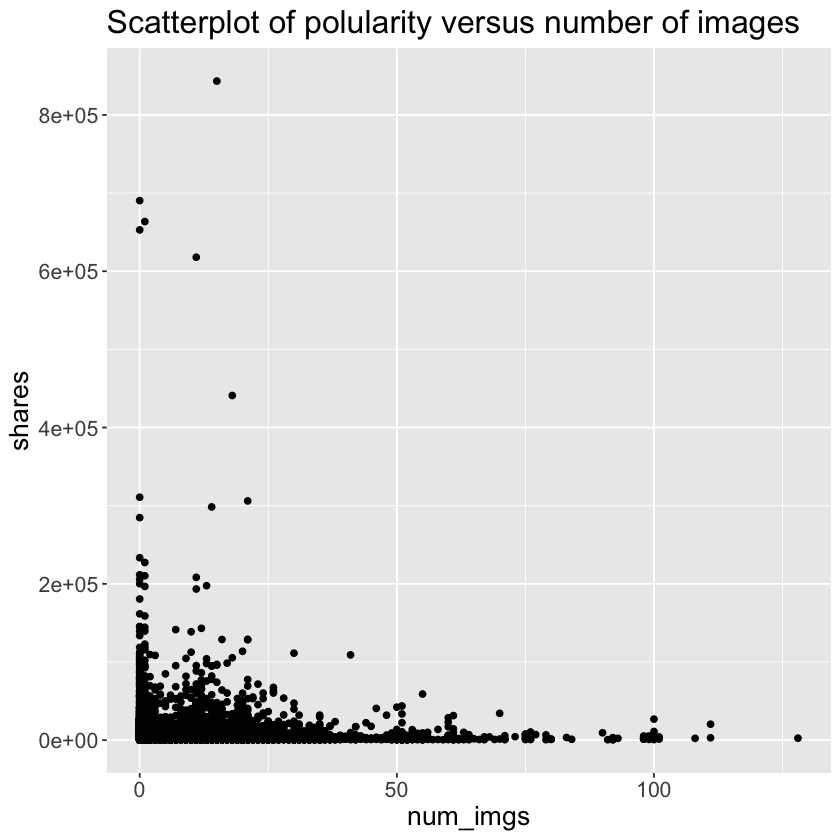

In [124]:
# drawing scatterplot of shares versus num_imgs
ggplot(news.data, mapping = aes(num_imgs, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of images")

Using 0 to 20 images is recommended.

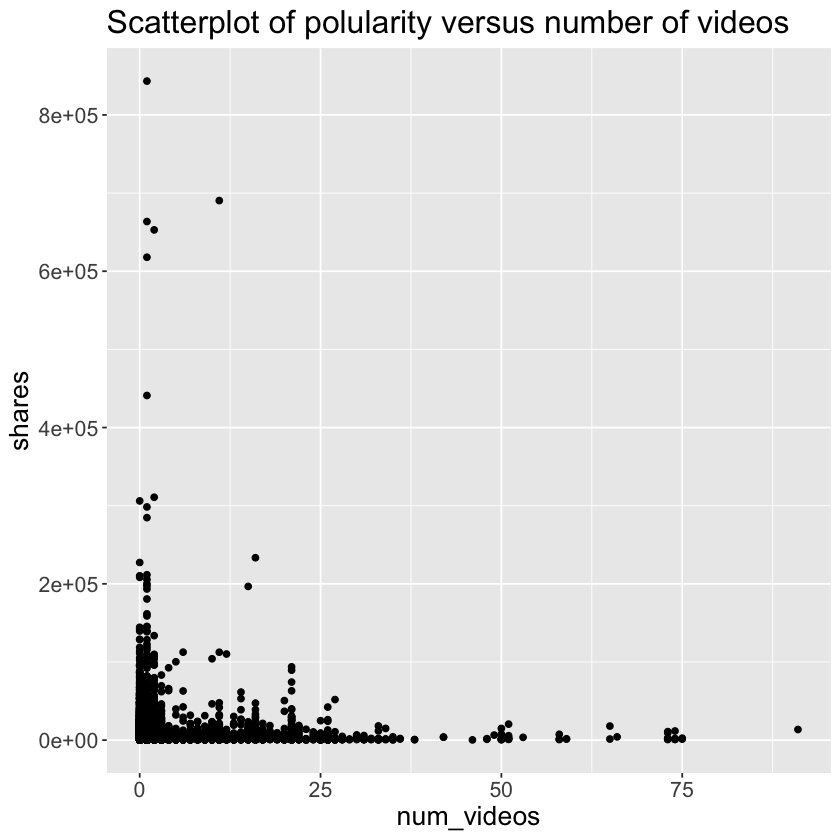

In [125]:
# drawing scatterplot of shares versus num_videos
ggplot(news.data, mapping = aes(num_videos, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of videos")

Using 1 to 3 videos is recommended.

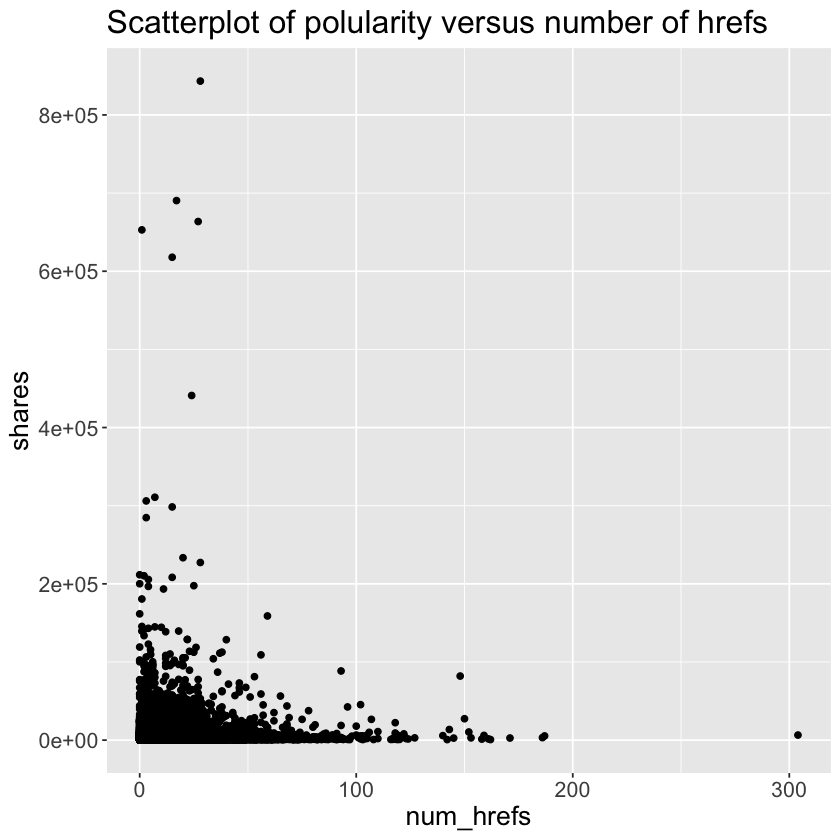

In [126]:
# drawing scatterplot of shares versus num_hrefs
ggplot(news.data, mapping = aes(num_hrefs, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of hrefs")

Using 0 to 25 hrefs is recommended.

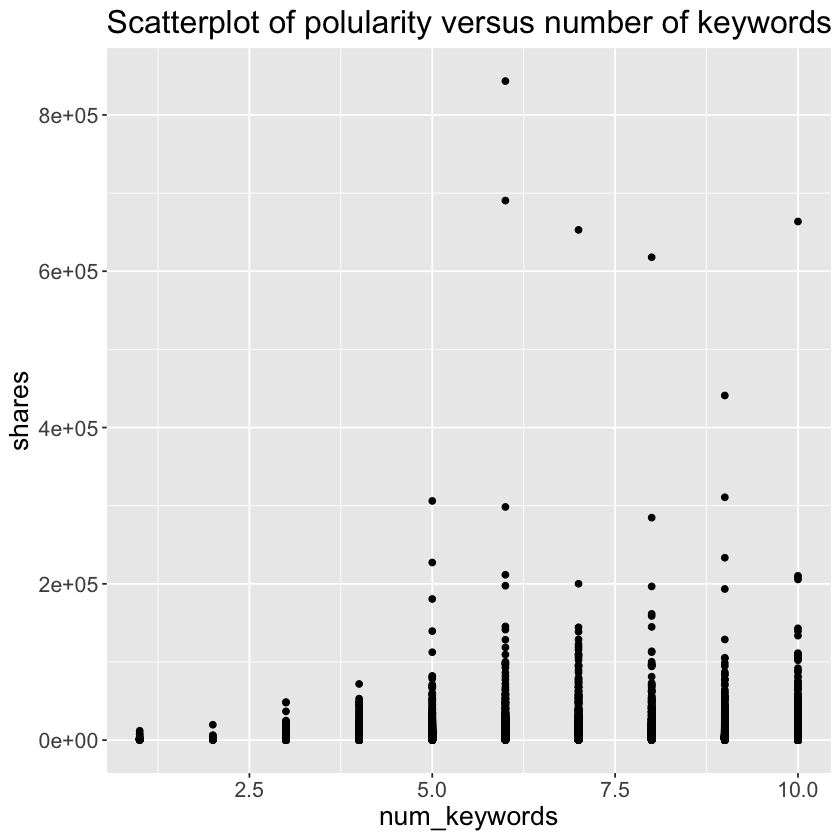

In [128]:
# drawing scatterplot of shares versus num_keywords
ggplot(news.data, mapping = aes(num_keywords, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of keywords")

Using 6 to 10 keywords is recommended.

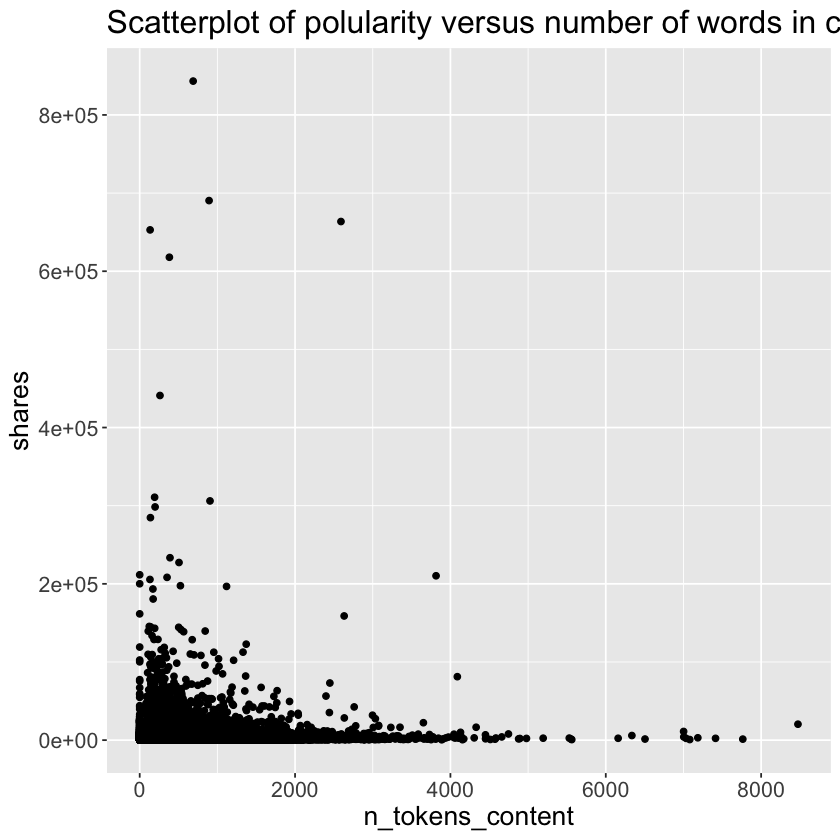

In [127]:
# drawing scatterplot of shares versus num_words in content
ggplot(news.data, mapping = aes(n_tokens_content, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of words in content")

Using 1000 words or less in content is recommended.

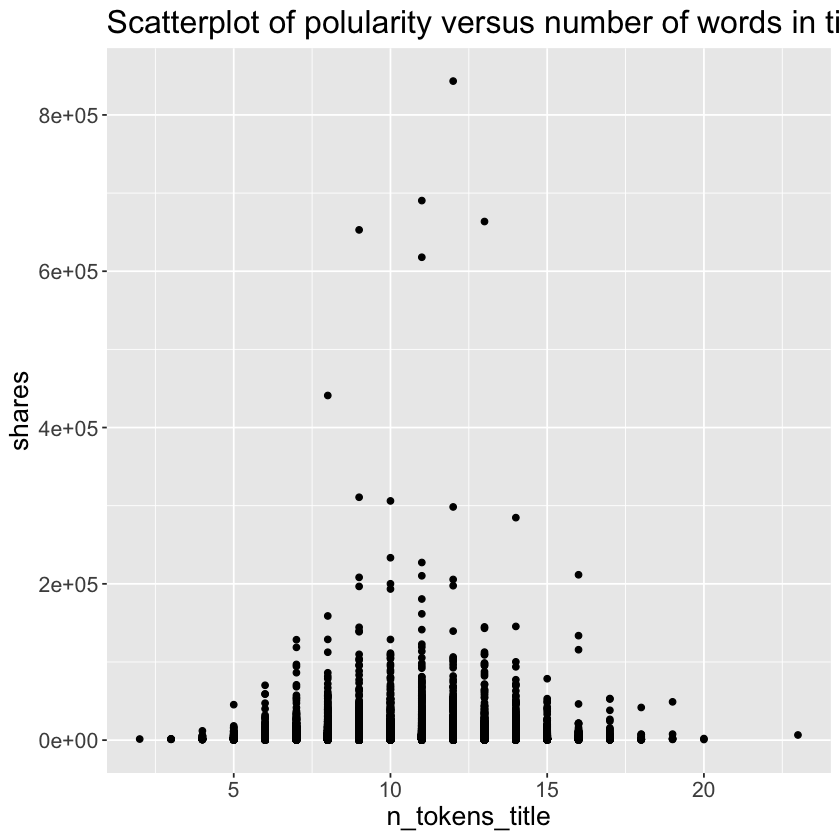

In [130]:
# drawing scatterplot of shares versus num_words in title
theme_update(text = element_text(size=16))
ggplot(news.data, mapping = aes(n_tokens_title, shares)) +
  geom_point() +
  labs(title = "Scatterplot of polularity versus number of words in title")

Using 9 to 12 words in title is recommended.

#### Which combo of news channels and text polarity will gain the most popularity?

In [15]:
# making a dataframe for news channel
df.channel <- select(news.data, c(14:19, 61))
df.channel$channel <- NA
df.channel$channel[which(df.channel$data_channel_is_lifestyle==1)] = "Lifestyle"
df.channel$channel[which(df.channel$data_channel_is_entertainment==1)] = "Entertainment"
df.channel$channel[which(df.channel$data_channel_is_bus==1)] = "Business"
df.channel$channel[which(df.channel$data_channel_is_socmed==1)] = "Social Media"
df.channel$channel[which(df.channel$data_channel_is_tech==1)] = "Technology"
df.channel$channel[which(df.channel$data_channel_is_world==1)] = "World"

# joining 2 dataframes
df.channel <- select(df.channel, c(channel, shares))
df.polarity.word <- select(df.polarity.word, c(shares, polarity))

df.combo.channel.word <- cbind(df.polarity.word$polarity, df.channel)
names(df.combo.channel.word) <- c("polarity", "channel", "shares")
df.combo.channel.word <- na.omit(df.combo.channel.word)

# for the same polarity and news channel (groupby), calculate the avg shares of each group
df.combo.channel.word.avg <- df.combo.channel.word %>% 
  group_by(channel, polarity) %>%
  summarise(avg_shares = mean(shares, na.rm = TRUE))
# arrange the table by descending order, showing the top 6
head(arrange(df.combo.channel.word.avg, desc(avg_shares)))

channel,polarity,avg_shares
<chr>,<fct>,<dbl>
Social Media,Positive,3672.904
Lifestyle,Positive,3655.345
Lifestyle,Negative,3314.975
Social Media,Negative,3314.758
Entertainment,Negative,3116.337
Technology,Positive,3084.614


The best combo of news channel and word polarity is Social Media channel with positive content.

#### Which combo of weekday and text polarity will gain the most popularity?

In [16]:
# assigning weekday value for advancing groupby
df.weekday$weekday <- NA
df.weekday$weekday[which(df.weekday$weekday_is_monday==1)] = "Monday"
df.weekday$weekday[which(df.weekday$weekday_is_tuesday==1)] = "Tuesday"
df.weekday$weekday[which(df.weekday$weekday_is_wednesday==1)] = "Wednesday"
df.weekday$weekday[which(df.weekday$weekday_is_thursday==1)] = "Thursday"
df.weekday$weekday[which(df.weekday$weekday_is_friday==1)] = "Friday"
df.weekday$weekday[which(df.weekday$weekday_is_saturday==1)] = "Saturday"
df.weekday$weekday[which(df.weekday$weekday_is_sunday==1)] = "Sunday"

# joining 2 dataframes
df.weekday <- select(df.weekday, c(weekday, shares))

df.combo.weekday.word <- cbind(df.polarity.word$polarity, df.weekday)
names(df.combo.weekday.word) <- c("polarity", "weekday", "shares")
df.combo.weekday.word <- na.omit(df.combo.weekday.word)

# for the same polarity and weekday (groupby), calculate the avg sahres of each group
df.combo.weekday.word.avg <- df.combo.weekday.word %>% 
  group_by(polarity, weekday) %>%
  summarise(avg_shares = mean(shares, na.rm = TRUE))
# arrange the table by descending order, showing the top 6
head(arrange(df.combo.weekday.word.avg, desc(avg_shares)))

polarity,weekday,avg_shares
<fct>,<chr>,<dbl>
Positive,Saturday,4036.489
Positive,Sunday,3758.516
Positive,Monday,3635.480
Negative,Sunday,3564.000
Negative,Saturday,3425.368
Positive,Wednesday,3344.953


The best combo of publish weekday and word polarity is Saturday with positive content.

#### Which combo of weekday and channel will gain the most popularity?

In [17]:
# joining 2 dataframes
df.combo.weekday.channel <- cbind(df.channel$channel, df.weekday)
names(df.combo.weekday.channel) <- c("channel", "weekday", "shares")
df.combo.weekday.channel <- na.omit(df.combo.weekday.channel)

# for the same news channel and weekday (groupby), calculate the avg sahres of each group
df.combo.weekday.channel.avg <- df.combo.weekday.channel %>% 
  group_by(channel, weekday) %>%
  summarise(avg_shares = mean(shares, na.rm = TRUE))
# arrange the table by descending order, showing the top 6
head(arrange(df.combo.weekday.channel.avg, desc(avg_shares)))

channel,weekday,avg_shares
<fct>,<chr>,<dbl>
Social Media,Sunday,4525.350
Business,Saturday,4426.897
Lifestyle,Monday,4345.711
Lifestyle,Tuesday,4152.494
Lifestyle,Saturday,4062.451
Social Media,Friday,4012.880


The best combo of publish weekday and word polarity is Social Media and Sunday. Therefore, the best strategy to gain popularity is to publish on Social Media channel on Sunday.

#### Does lifestyle/entertainment/business/social media/tech/world channel increase the popularity over time?

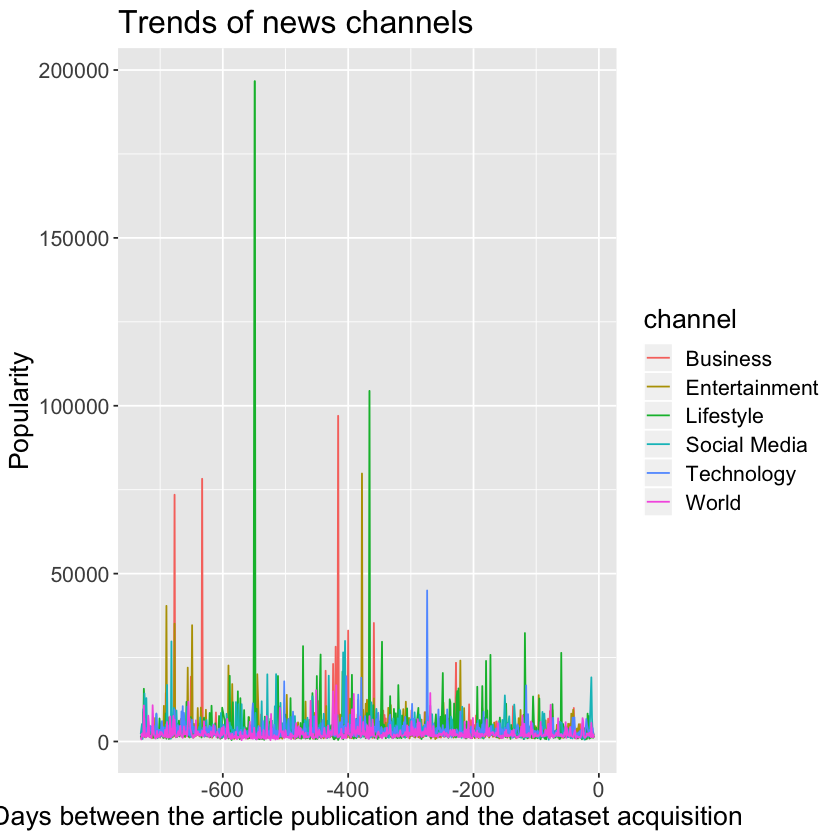

In [131]:
# making a dataframe for time series analysis containing time data, data channel and share.
df.ts <- select(news.data, c(2,14:19, 61))
df.ts$channel <- NA
df.ts$channel[which(df.ts$data_channel_is_lifestyle==1)] = "Lifestyle"
df.ts$channel[which(df.ts$data_channel_is_entertainment==1)] = "Entertainment"
df.ts$channel[which(df.ts$data_channel_is_bus==1)] = "Business"
df.ts$channel[which(df.ts$data_channel_is_socmed==1)] = "Social Media"
df.ts$channel[which(df.ts$data_channel_is_tech==1)] = "Technology"
df.ts$channel[which(df.ts$data_channel_is_world==1)] = "World"

# selecting the necessary column for time series analysis
df.ts <- select(df.ts, c(timedelta, channel, shares))
df.ts <- na.omit(df.ts)

# For the same date for the same news channel, calculate the mean value of shares.
df.ts.avg <- df.ts %>% 
  group_by(timedelta, channel) %>%
  summarise(avg_shares = mean(shares, na.rm = TRUE))

# Drawing a ggplot and showing its legend
ggplot(df.ts.avg) +
    geom_line(aes(x=0-timedelta, y=avg_shares, color=channel)) +
    labs(title = "Trends of news channels", y = "Popularity", x = "Days between the article publication and the dataset acquisition")

According to the plot, none of the 6 news channel has the increasing trend of popularity. Also, Lifestyle channel and Business channel are more likely to acchieve an extremely high hits.

## 3 Model: Regression

#### Objective: Find the best model to predict the number of shares in social networks (popularity).

#### Methodology: Spliting data into trainning set and test set. Using the trainning set to train the models (Traditional Linear Regression, Lasso, Ridge Regression, Stepwise, PCA). Using the test set to validate the prediction. Using MSE and number of predictors as model selecting criterions.

### 3.1 Data Preparation for regression

#### Omiting the unnecessary variables:
url: unpredictable

timedelta: unnecessary

is_weekend: overlap

In [19]:
# Omiting the unnecessary predictors
reg.data <- subset(news.data, select = -c(url, timedelta, is_weekend))

#### Transform variables of weekday types and data channel type to factor type

In [20]:
reg.data[,12:17] <- lapply(reg.data[,12:17], factor)
reg.data[,30:36] <- lapply(reg.data[,30:36], factor)

#### Detecting and removing outliers

Using data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday as id variables



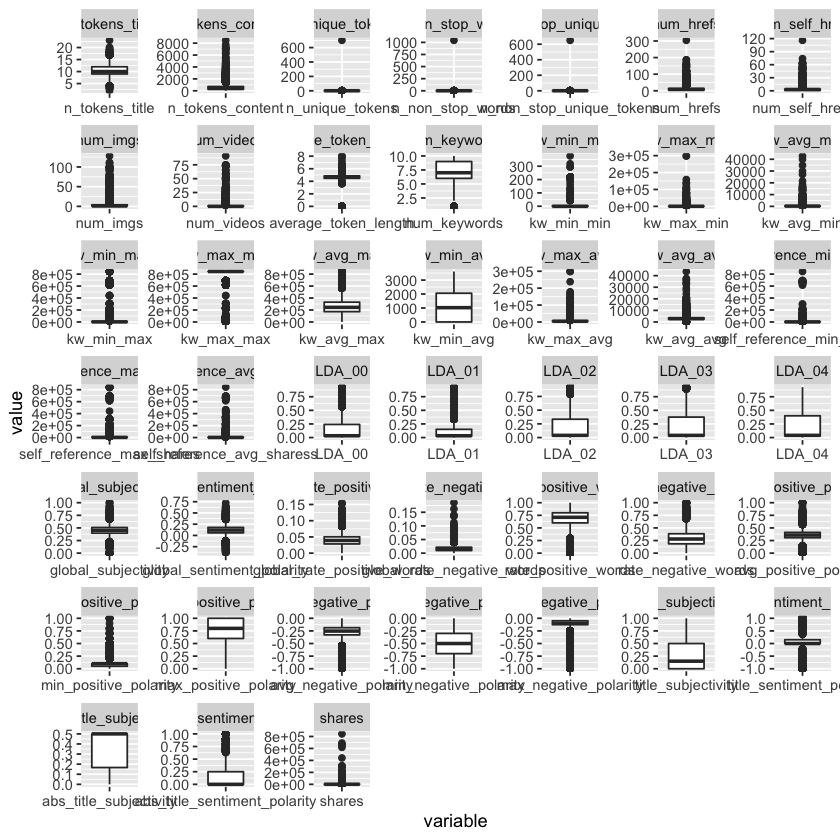

In [21]:
# melt and reshape data as variable and value
melted.reg.data <- melt(reg.data)

# make a ggplot table to have an overall understanding of outliers
ggplot(melted.reg.data, aes(variable, value)) + 
  geom_boxplot() + 
  facet_wrap(~variable, scale="free")

According to the ggplot table, the variable "n_unique_tokens", "n_non_stop_words", and "n_non_stop_unique_tokens" seems to have outliers. Therefore, we need to take a closer look at the predictors that seems to have outliers.

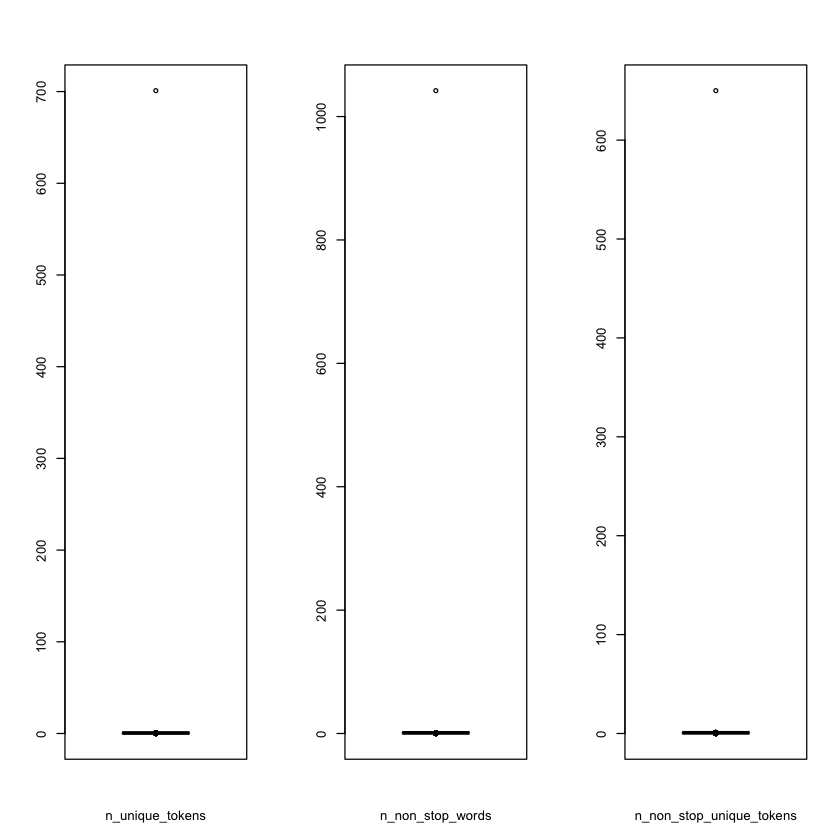

In [22]:
# arrange the boxplot matrix to a better look
par(mfrow=c(1,3))
# draw boxplot to detect outliers
boxplot(reg.data$n_unique_tokens, xlab="n_unique_tokens")
boxplot(reg.data$n_non_stop_words, xlab="n_non_stop_words")
boxplot(reg.data$n_non_stop_unique_tokens, xlab="n_non_stop_unique_tokens")

According to the boxplots above, outliers do exit. Hence, we need to remove outliers in case they influence the regression result violently.

In [23]:
reg.data <- reg.data[-c(which(reg.data$n_unique_tokens>100),
                        which(reg.data$n_non_stop_words>200),
                        which(reg.data$n_non_stop_unique_tokens>100)),]

### 3.2 Traditional Linear Regression

#### Train-test split

In [24]:
# Split the data into a training set and a test set
n <- nrow(reg.data)
test <- sample(1:n, 0.25*n)
train <- setdiff(1:n, test)

#### Fitting traditional Linear Regression model

In [25]:
reg.fm1 <- lm(shares~., data = reg.data, subset = train)
summary(reg.fm1)


Call:
lm(formula = shares ~ ., data = reg.data, subset = train)

Residuals:
   Min     1Q Median     3Q    Max 
-30474  -2334  -1212    -43 683540 

Coefficients: (2 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -1.972e+03  1.056e+03  -1.867 0.061975 .  
n_tokens_title                  7.990e+01  3.368e+01   2.373 0.017668 *  
n_tokens_content                7.534e-01  2.588e-01   2.911 0.003604 ** 
n_unique_tokens                 5.402e+03  2.253e+03   2.397 0.016521 *  
n_non_stop_words               -8.091e+02  6.083e+03  -0.133 0.894180    
n_non_stop_unique_tokens       -2.626e+03  1.914e+03  -1.372 0.170055    
num_hrefs                       1.966e+01  7.758e+00   2.534 0.011281 *  
num_self_hrefs                 -4.940e+01  2.082e+01  -2.373 0.017670 *  
num_imgs                        5.192e+00  1.036e+01   0.501 0.616213    
num_videos                      5.055e+00  1.867e+01   

In [26]:
pred.all <- predict(reg.fm1, reg.data[test,])
sqrt(mean((reg.data$shares[test] - pred.all)^2))

Warning message in predict.lm(reg.fm1, reg.data[test, ]):
“prediction from a rank-deficient fit may be misleading”


[1] 10810.85

The RSS is extremely large. Take a look at the histogram of the respose variable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



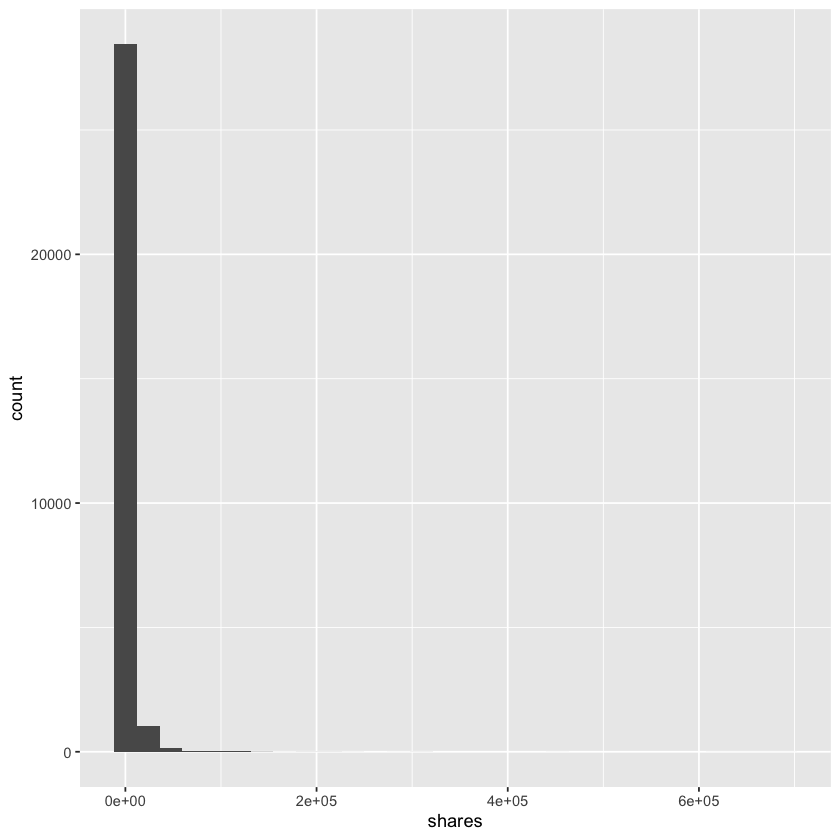

In [27]:
# ggplot histogram
ggplot(reg.data[train,], aes(shares)) +
  geom_histogram()

Values of shares do not evenly distributed along the range. Therefore, transformation of reponse valuable is needed.
Fit the second traditional Linear Regression model with the log value.

In [28]:
# making a new dataframe using log(shares) as response
reg.data$logshares <- log(reg.data$shares)
reg.data.log <- subset(reg.data, select = -c(shares))
# fitting the traditional regression model using the new data frame.
reg.fm2 <- lm(logshares~., data = reg.data.log, subset = train)
summary(reg.fm2)


Call:
lm(formula = logshares ~ ., data = reg.data.log, subset = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1027 -0.5455 -0.1625  0.3906  5.5662 

Coefficients: (2 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     6.777e+00  7.831e-02  86.540  < 2e-16 ***
n_tokens_title                  5.537e-03  2.496e-03   2.218 0.026573 *  
n_tokens_content                4.284e-05  1.918e-05   2.234 0.025521 *  
n_unique_tokens                 1.205e-01  1.670e-01   0.721 0.470693    
n_non_stop_words                1.194e-01  4.509e-01   0.265 0.791138    
n_non_stop_unique_tokens       -1.920e-01  1.419e-01  -1.353 0.176001    
num_hrefs                       3.807e-03  5.751e-04   6.621 3.63e-11 ***
num_self_hrefs                 -7.454e-03  1.543e-03  -4.829 1.38e-06 ***
num_imgs                        2.376e-03  7.679e-04   3.094 0.001974 ** 
num_videos                      2.170e

In [29]:
pred.all.log <- predict(reg.fm2, reg.data.log[test,])
sqrt(mean((reg.data.log$logshares[test] - pred.all.log)^2))

Warning message in predict.lm(reg.fm2, reg.data.log[test, ]):
“prediction from a rank-deficient fit may be misleading”


[1] 0.8748058

The RSS is a lot smaller now.

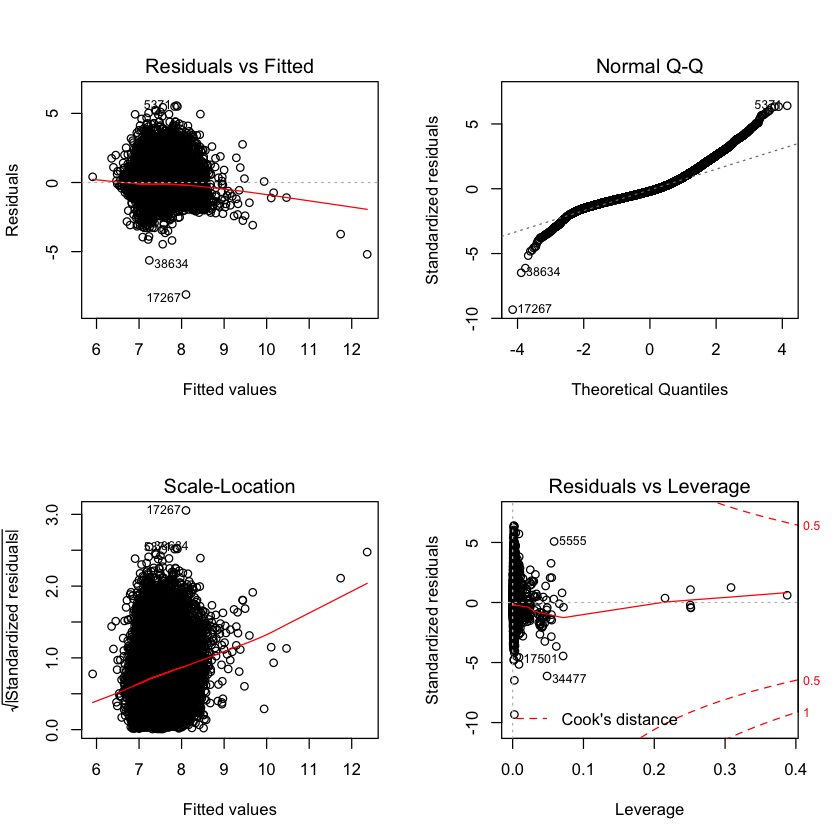

In [30]:
# Draw some diagnose plots
par(mfrow=c(2,2))
plot(reg.fm2)

According to the diagnose plots, the model is slightly affected by outliers.

### 3.3 Variable Selection (Lasso model)

In [31]:
# using model.matrix to make dummy variables
x <- model.matrix(logshares ~ ., reg.data.log)[,-1]
y <- reg.data.log$logshares

# using cross validation to find a good lambda
reg.fm.lasso <- cv.glmnet(x[train,], y[train], alpha = 1)
# print the num of variable, lambda, MSE, after fitting the model
print(reg.fm.lasso)


Call:  cv.glmnet(x = x[train, ], y = y[train], alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Measure      SE Nonzero
min 0.000511  0.7581 0.01115      51
1se 0.014552  0.7684 0.01161      26


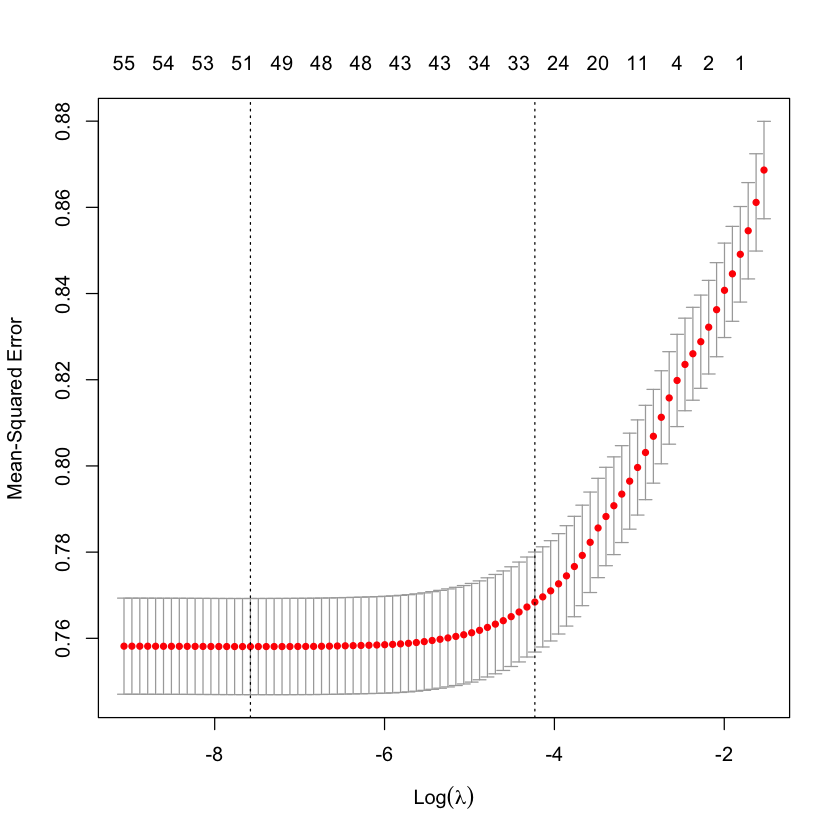

In [32]:
plot(reg.fm.lasso)

According to the summary and plot of the Lasso model, choosing the minimum lambda can achieve the least Mean-Squared Error (MSE) of 0.7581 with 51 predictors. However, using large number of predictor may incur issue of overfitting.

Choosing the one standard error next to the minimum lambda can achieve the least Mean-Squared Error (MSE) of 0.7684 with 26 predictors. This may prevent the overfit issue and the MSE does not increase a lot.

Therefore, we choose lambda.1se as the parameter to fit the Lasso model. The predictors of the model are:

In [33]:
lambda.1se.lasso <- reg.fm.lasso$lambda.1se
# Printing the predictors of Lasso model
(lasso.coef1 = predict(reg.fm.lasso, type="coefficients", s = lambda.1se.lasso))

58 x 1 sparse Matrix of class "dgCMatrix"
                                           1
(Intercept)                     6.818530e+00
n_tokens_title                  .           
n_tokens_content                .           
n_unique_tokens                -1.508509e-01
n_non_stop_words                .           
n_non_stop_unique_tokens       -1.535258e-02
num_hrefs                       2.946792e-03
num_self_hrefs                  .           
num_imgs                        1.368538e-03
num_videos                      .           
average_token_length           -6.090659e-03
num_keywords                    1.636271e-02
data_channel_is_lifestyle1      .           
data_channel_is_entertainment1 -1.577577e-01
data_channel_is_bus1           -1.415212e-02
data_channel_is_socmed1         1.984893e-01
data_channel_is_tech1           8.030583e-02
data_channel_is_world1          .           
kw_min_min                      5.808607e-04
kw_max_min                      .           
kw_avg_min   

### 3.4 Variable Selection (Ridge Regression)

In [34]:
reg.fm.ridge <- cv.glmnet(x[train,], y[train], alpha = 0)
# print the num of variable, lambda, MSE, after fitting the model
print(reg.fm.ridge)


Call:  cv.glmnet(x = x[train, ], y = y[train], alpha = 0) 

Measure: Mean-Squared Error 

     Lambda Measure       SE Nonzero
min 0.02161  0.7592 0.009983      57
1se 0.20152  0.7687 0.009995      57


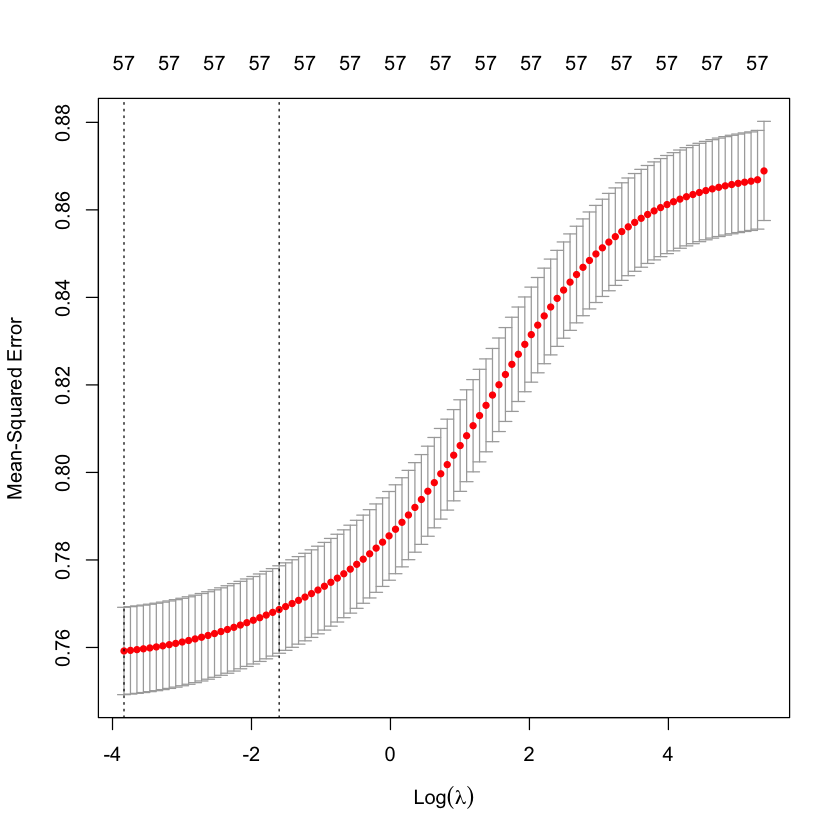

In [35]:
plot(reg.fm.ridge)

According to the summary and plot of the Lasso model, choosing the minimum lambda can achieve the least Mean-Squared Error (MSE) of 0.7592 with 57 predictors. Choosing one standard error next to the minimum lambda can achieve the least Mean-Squared Error (MSE) of 0.7687 with 57 predictors. However, using large number of predictor may incur issue of overfitting.

### 3.5 Variable Selection (Stepwise Selection)
Using AIC as selection criterion to do stepwise variable selection.

In [ ]:
reg.fm.step <- step(reg.fm2)

In [40]:
print(reg.fm.step)


Call:
lm(formula = logshares ~ n_tokens_title + n_tokens_content + 
    n_non_stop_unique_tokens + num_hrefs + num_self_hrefs + num_imgs + 
    num_videos + average_token_length + num_keywords + data_channel_is_lifestyle + 
    data_channel_is_entertainment + data_channel_is_bus + data_channel_is_socmed + 
    data_channel_is_tech + kw_min_min + kw_avg_min + kw_min_max + 
    kw_avg_max + kw_min_avg + kw_max_avg + kw_avg_avg + self_reference_min_shares + 
    self_reference_avg_sharess + weekday_is_monday + weekday_is_tuesday + 
    weekday_is_wednesday + weekday_is_thursday + weekday_is_friday + 
    LDA_00 + LDA_01 + LDA_02 + LDA_03 + global_subjectivity + 
    global_rate_positive_words + rate_positive_words + rate_negative_words + 
    min_positive_polarity + max_positive_polarity + avg_negative_polarity + 
    title_subjectivity + title_sentiment_polarity + abs_title_subjectivity, 
    data = reg.data.log, subset = train)

Coefficients:
                   (Intercept)             

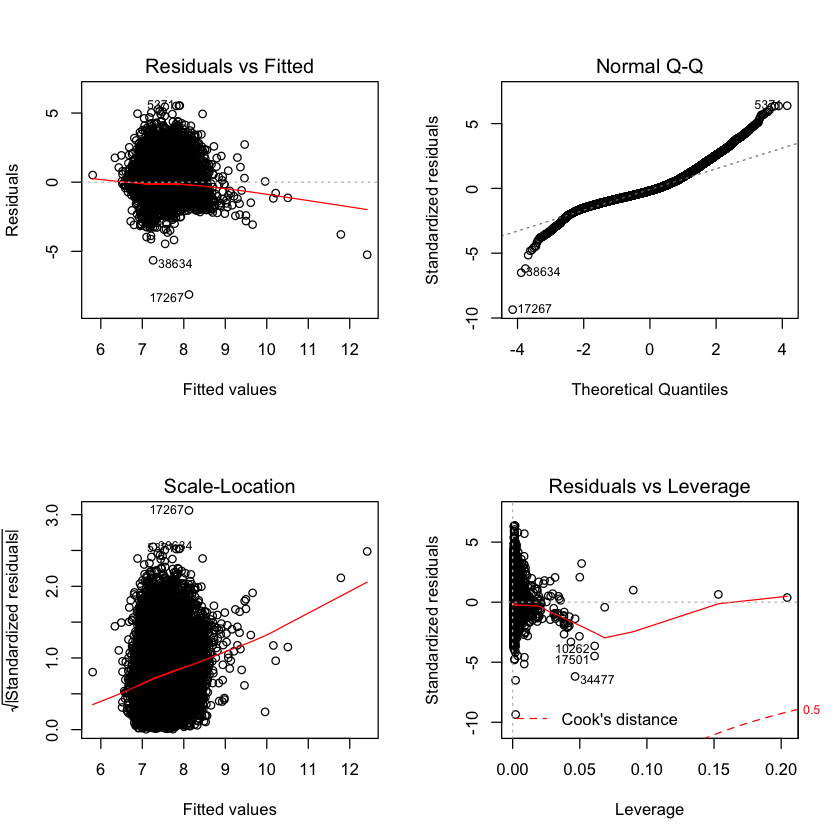

In [38]:
# make some diagnose plot
par(mfrow=c(2,2))
plot(reg.fm.step)

As a result, the stepwise model use 42 predictors to predict the reponse share. According to the diagnose plots, the model is affected by outliers.

### 3.6 Variable Selection (PCA)

In [39]:
set.seed(1)
reg.fm.pca <- pcr(logshares~., data = reg.data.log, subset = train)
summary(reg.fm.pca)

Data: 	X dimension: 29733 57 
	Y dimension: 29733 1
Fit method: svdpc
Number of components considered: 57
TRAINING: % variance explained
            1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X          76.33854  92.6086   96.063   99.390   99.897   99.957   99.986
logshares   0.03886   0.5372    1.026    1.232    1.304    2.182    2.183
           8 comps  9 comps  10 comps  11 comps  12 comps  13 comps  14 comps
X           100.00   99.999   100.000   100.000   100.000    100.00   100.000
logshares     2.35    4.296     6.549     8.861     8.862      9.04     9.228
           15 comps  16 comps  17 comps  18 comps  19 comps  20 comps  21 comps
X           100.000   100.000   100.000   100.000   100.000   100.000    100.00
logshares     9.228     9.235     9.235     9.238     9.469     9.484     10.24
           22 comps  23 comps  24 comps  25 comps  26 comps  27 comps  28 comps
X            100.00    100.00    100.00    100.00    100.00    100.00    100.00
logshar

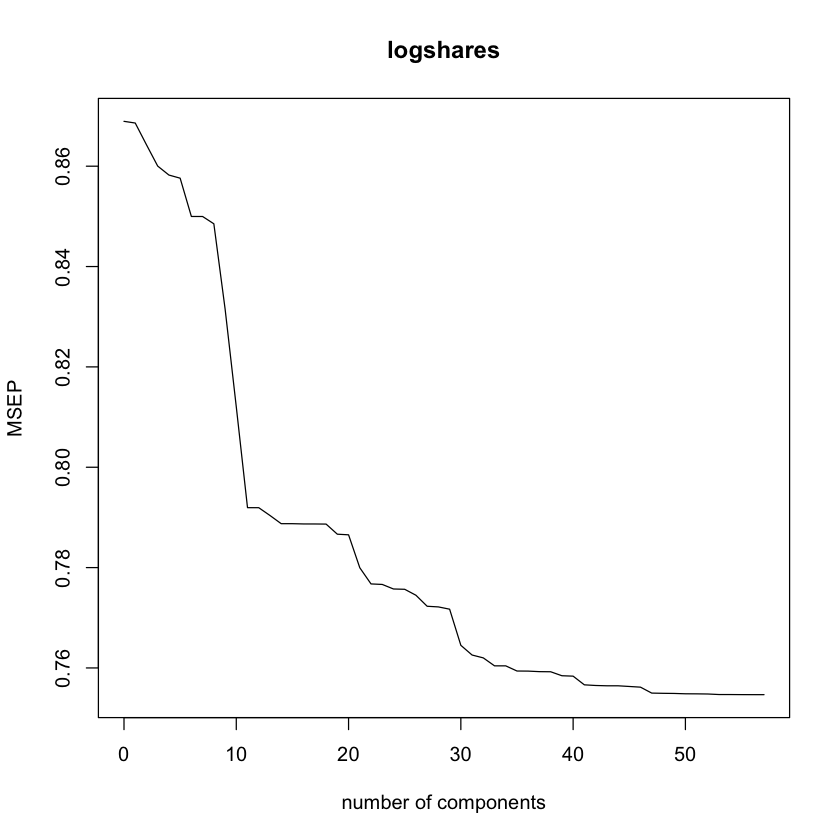

In [41]:
validationplot(reg.fm.pca, val.type="MSEP")

The valication plot shows how MSE drop as adding more predictors. According to the summary and plot, when adding to 10 predictors, MSE drops to about 0.79. When adding to 30 predictors, MSE drops to about 0.76. After that, adding more predictors does change much of the MSE. Therefore, we choose 30 predictors to predict, preventing bias and overfit issues.

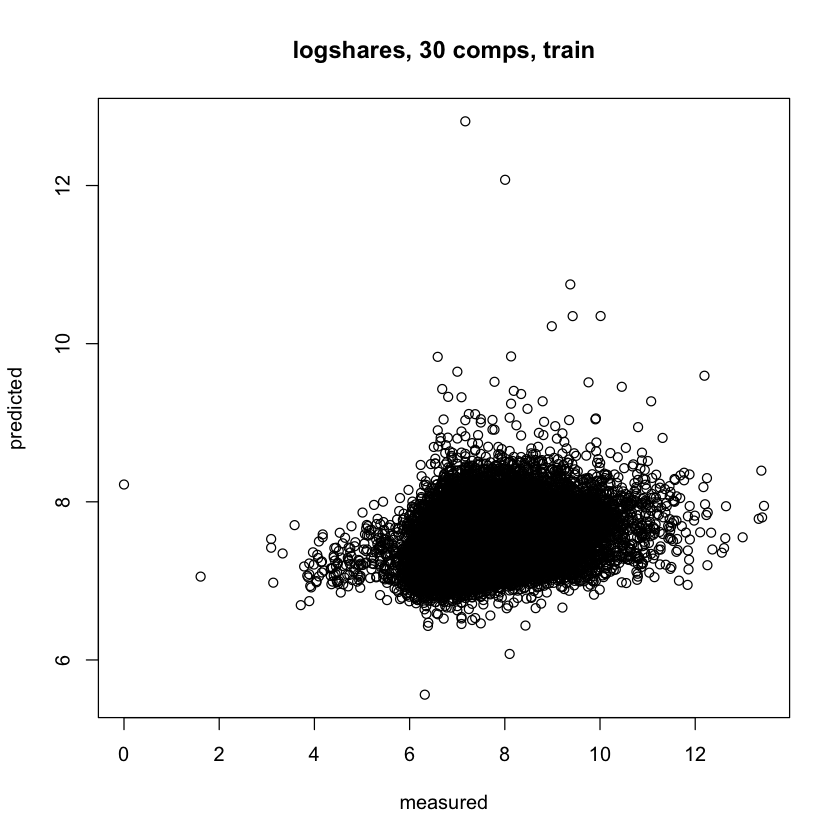

In [42]:
plot(reg.fm.pca, ncomp = 30)

### 3.7 Comparison (ols, Lasso, Ridge, Stepwise, PCA)

#### Using number of predictors and MSE as criterion

#### Traditional Linear Regression

In [43]:
# make prediction on test set
ypred.ols <- predict(reg.fm2, reg.data.log[test,])
# calculate the MSE of using ols
(mse.ols <- mean((ypred.ols - y[test])^2))

Warning message in predict.lm(reg.fm2, reg.data.log[test, ]):
“prediction from a rank-deficient fit may be misleading”


[1] 0.7652852

Number of predictors: 57 

MSE:0.765285182089207

#### Lasso

In [44]:
# make prediction on test set
ypred.lasso <- predict(reg.fm.lasso, newx=x[test,], s = lambda.1se.lasso)
# calculate the MSE of using Lasso
(mse.lasso <- mean((ypred.lasso - y[test])^2))

[1] 0.771744

Number of predictors: 26 

MSE: 0.771744049425363

#### Ridge Regression

In [45]:
lambda.min.ridge <- reg.fm.ridge$lambda.min # the lamda that minimizes training MSE
# make prediction on test set
ypred.ridge <- predict(reg.fm.ridge, newx=x[test,], s = lambda.min.ridge)
# calculate the MSE of using Ridge Regression
(mse.ridge <- mean((ypred.ridge - y[test])^2))

[1] 0.7651705

Number of predictors: 57

MSE: 0.765170525367947

#### Stepwise Selection

In [47]:
# make prediction on test set
ypred.step <- predict(reg.fm.step, reg.data.log[test,])
# calculate the MSE of using Stepwise Selection
(mse.step <- mean((ypred.step - y[test])^2))

[1] 0.7654207

Number of predictors: 42

MSE: 0.765420698773631

#### PCA

In [49]:
# make prediction on test set
ypred.pca <- predict(reg.fm.pca, reg.data.log[test,], ncomp = 30)
# calculate the MSE of using PCA
(mse.pca <- mean((ypred.pca - y[test])^2))

[1] 0.7730316

Number of predictors: 30

MSE: 0.773031594914064

### Result: Best model: Lasso, PCA

## 4 Model: Classification

### 4.1 Data Preparation for classfication

In [74]:
#Deleting URL and timedelta columns
cla.data <- subset(news.data, select = -c(url, timedelta))

#Standardize the data
cla.data <- data.frame(apply(cla.data , 2, function(x) as.numeric(as.character(x)))) #convert into numeric
for(i in 1:58){ 
  cla.data[,i]<-scale(cla.data[,i], center = T, scale = T)}

#Define articles with shares larger than 1400 (median) as popular article
# Dataset for classification
cla.data <- data.frame(apply(cla.data , 2, function(x) as.numeric(as.character(x)))) #convert into numeric
cla.data$shares <- as.factor(ifelse(cla.data$shares > 1400, 1, 0))

#Split the data train 80% test 20%
set.seed(1)
#Select traning data and prediction data
ind<-sample(2, nrow(cla.data), replace=T, prob=c(0.8,0.2))

#Color palatte
color.knn<-'#00B2FF'#blue for KNN
color.cart<-'#FF1300' #red for cart
color.rf<-'#cd00ff' # purple for random forest
color.boost<-'#32ff00' # green for boosting

### 4.2 KNN

In [51]:
# Fitting the knn model
newscla.knn <- knn3(shares ~., cla.data[ind==1,])
# make prediction on the test set
newscla.knn.pred <- predict(newscla.knn, cla.data[ind==2,], type="class")
newscla.knn.prob <- predict(newscla.knn, cla.data[ind==2,], type="prob")

In [52]:
# Confusion matrix of knn model
confusionMatrix(newscla.knn.pred, cla.data[ind==2,]$shares)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2606 1740
         1 1373 2174
                                          
               Accuracy : 0.6056          
                 95% CI : (0.5947, 0.6164)
    No Information Rate : 0.5041          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2105          
                                          
 Mcnemar's Test P-Value : 5.387e-11       
                                          
            Sensitivity : 0.6549          
            Specificity : 0.5554          
         Pos Pred Value : 0.5996          
         Neg Pred Value : 0.6129          
             Prevalence : 0.5041          
         Detection Rate : 0.3302          
   Detection Prevalence : 0.5506          
      Balanced Accuracy : 0.6052          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



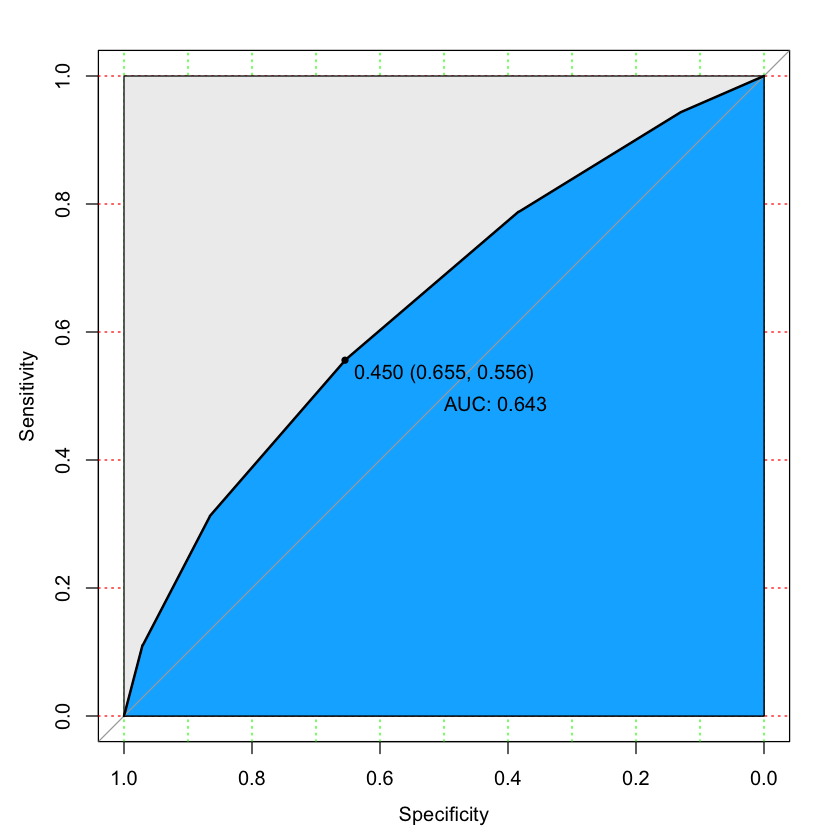

In [53]:
# ROC Curve of knn
newscla.knn.roc <- roc(cla.data[ind==2,]$shares, newscla.knn.prob[,2])
plot(newscla.knn.roc, print.auc=T,
     auc.polygon=T, grid=c(0.1,0.2), grid.col=c("green","red"),
     max.auc.polygon=T, auc.polygon.col=color.knn, print.thres=T)

### 4.3 CART

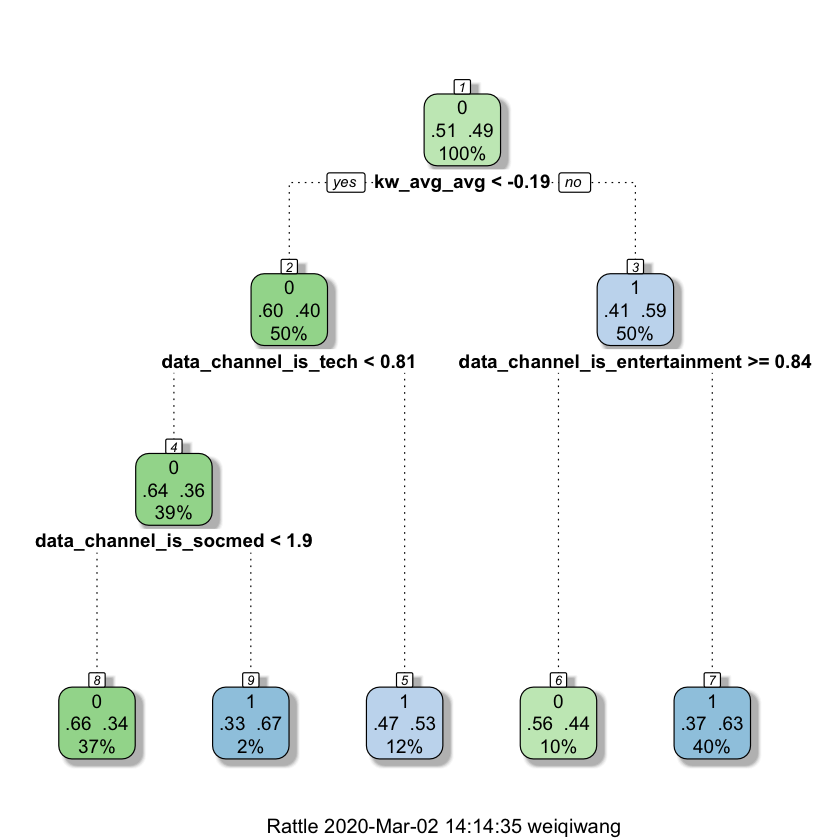

In [54]:
# CART
newscla.cart<-rpart(shares ~., cla.data[ind==1,], method='class')
fancyRpartPlot(newscla.cart) #Generating nodes

In [55]:
summary(newscla.cart)
newscla.cart.pred <- predict(newscla.cart, cla.data[ind==2,], type="class")
newscla.cart.prob <- predict(newscla.cart, cla.data[ind==2,], type="prob")

Call:
rpart(formula = shares ~ ., data = cla.data[ind == 1, ], method = "class")
  n= 31751 

          CP nsplit rel error    xerror        xstd
1 0.18341002      0 1.0000000 1.0000000 0.005693054
2 0.02607362      1 0.8165900 0.8171651 0.005584853
3 0.01348415      2 0.7905164 0.7909637 0.005553667
4 0.01000000      4 0.7635481 0.7638037 0.005517018

Variable importance
                   kw_avg_avg                    kw_max_avg 
                           24                            15 
                   kw_min_avg                    kw_min_max 
                           10                             9 
                       LDA_03                    kw_avg_max 
                            9                             8 
data_channel_is_entertainment          data_channel_is_tech 
                            7                             6 
       data_channel_is_socmed                        LDA_04 
                            5                             4 
               

In [56]:
# Confusion matrix of CART model
confusionMatrix(newscla.cart.pred, cla.data[ind==2,]$shares)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2354 1359
         1 1625 2555
                                          
               Accuracy : 0.6219          
                 95% CI : (0.6111, 0.6327)
    No Information Rate : 0.5041          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2443          
                                          
 Mcnemar's Test P-Value : 1.227e-06       
                                          
            Sensitivity : 0.5916          
            Specificity : 0.6528          
         Pos Pred Value : 0.6340          
         Neg Pred Value : 0.6112          
             Prevalence : 0.5041          
         Detection Rate : 0.2982          
   Detection Prevalence : 0.4704          
      Balanced Accuracy : 0.6222          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



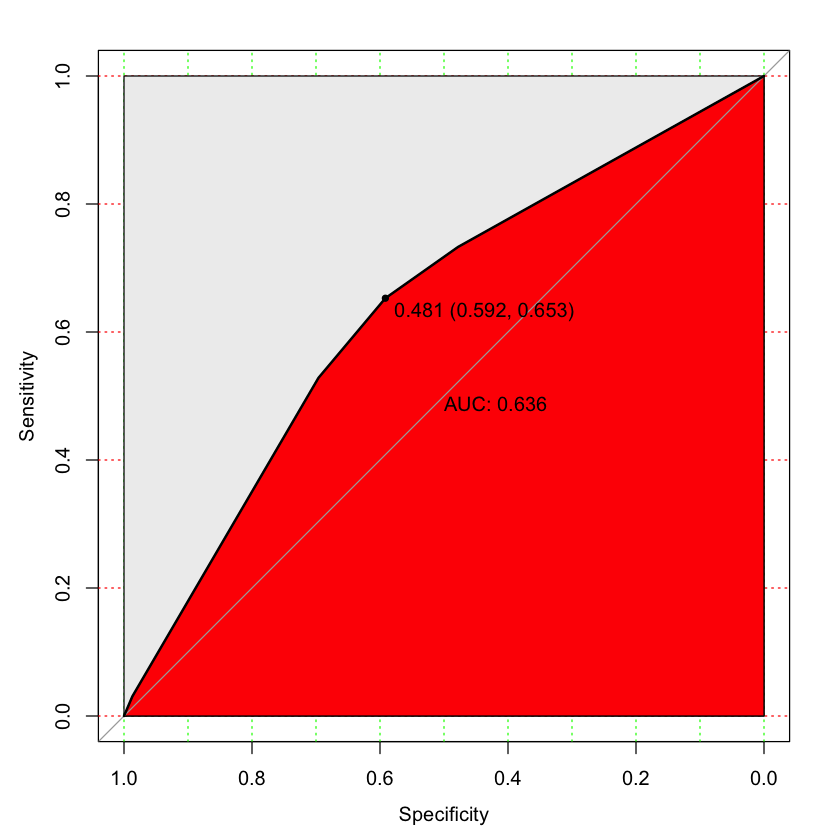

In [57]:
# ROC Curve of CART model
newscla.cart.roc <- roc(cla.data[ind==2,]$shares, newscla.cart.prob[,2])
plot(newscla.cart.roc, print.auc=T,
     auc.polygon=T, grid=c(0.1,0.2), grid.col=c("green","red"),
     max.auc.polygon=T, auc.polygon.col=color.cart, print.thres=T)

### 4.4 Random Forest

In [58]:
# Fitting the random forest model
newscla.rf <- randomForest(shares ~ ., cla.data[ind==1,],
                      do.trace=10, mtry=3, ntree=200,
                      na.action=na.omit, importance=TRUE)
# make prediction
newscla.rf.pred <- predict(newscla.rf, cla.data[ind==2,], type="class")
newscla.rf.prob <- predict(newscla.rf, cla.data[ind==2,], type="prob")

ntree      OOB      1      2
   10:  41.48% 37.47% 45.60%
   20:  39.22% 35.50% 43.05%
   30:  38.01% 35.25% 40.86%
   40:  37.15% 34.81% 39.55%
   50:  36.42% 34.29% 38.62%
   60:  35.89% 34.01% 37.81%
   70:  35.85% 34.25% 37.51%
   80:  35.74% 34.16% 37.37%
   90:  35.50% 33.98% 37.07%
  100:  35.39% 34.06% 36.76%
  110:  35.08% 33.81% 36.39%
  120:  34.94% 33.83% 36.07%
  130:  34.71% 33.52% 35.93%
  140:  34.75% 33.62% 35.92%
  150:  34.57% 33.64% 35.52%
  160:  34.56% 33.52% 35.63%
  170:  34.46% 33.35% 35.61%
  180:  34.37% 33.45% 35.31%
  190:  34.25% 33.21% 35.33%
  200:  34.38% 33.34% 35.45%


In [59]:
# Confusion matrix of Random Forest model
confusionMatrix(newscla.rf.pred, cla.data[ind==2,]$shares)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2666 1348
         1 1313 2566
                                          
               Accuracy : 0.6629          
                 95% CI : (0.6523, 0.6733)
    No Information Rate : 0.5041          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.3256          
                                          
 Mcnemar's Test P-Value : 0.5098          
                                          
            Sensitivity : 0.6700          
            Specificity : 0.6556          
         Pos Pred Value : 0.6642          
         Neg Pred Value : 0.6615          
             Prevalence : 0.5041          
         Detection Rate : 0.3378          
   Detection Prevalence : 0.5086          
      Balanced Accuracy : 0.6628          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



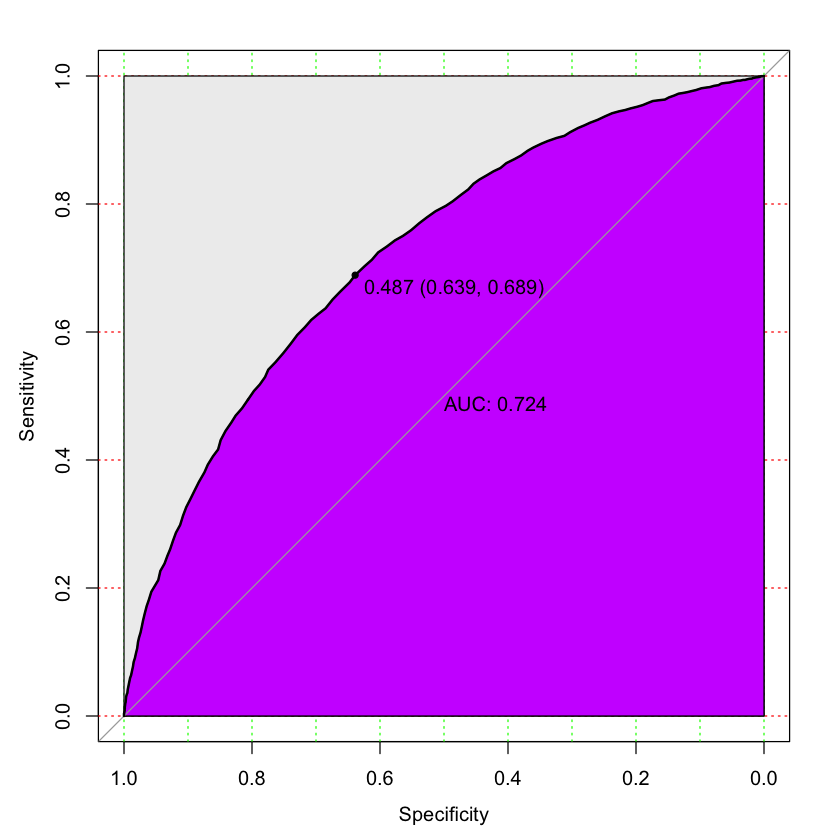

In [60]:
# ROC Curve of random forest
newscla.rf.roc <- roc(cla.data[ind==2,]$shares, newscla.rf.prob[,2])
plot(newscla.rf.roc, print.auc=T,
     auc.polygon=T, grid=c(0.1,0.2), grid.col=c("green","red"),
     max.auc.polygon=T, auc.polygon.col=color.rf, print.thres=T)

In [96]:
rf.importance <- data.frame(newscla.rf$importance)
rf.importance$var_name <- row.names(rf.importance)
head(arrange(rf.importance, desc(MeanDecreaseGini)))

,X0,X1,MeanDecreaseAccuracy,MeanDecreaseGini,var_name
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.012300463,0.0088003479,0.010571869,607.4897,kw_avg_avg
2,0.007388741,0.0064723561,0.006936277,546.9038,kw_max_avg
3,0.008683436,0.0007099597,0.004756812,472.1929,LDA_02
4,0.005035384,0.0086096366,0.006798184,442.9938,self_reference_avg_sharess
5,0.004041794,0.0089961257,0.006480847,438.1178,self_reference_min_shares
6,0.004509398,0.0022487063,0.003396479,437.9957,LDA_01


### 4.5 comparing the three models

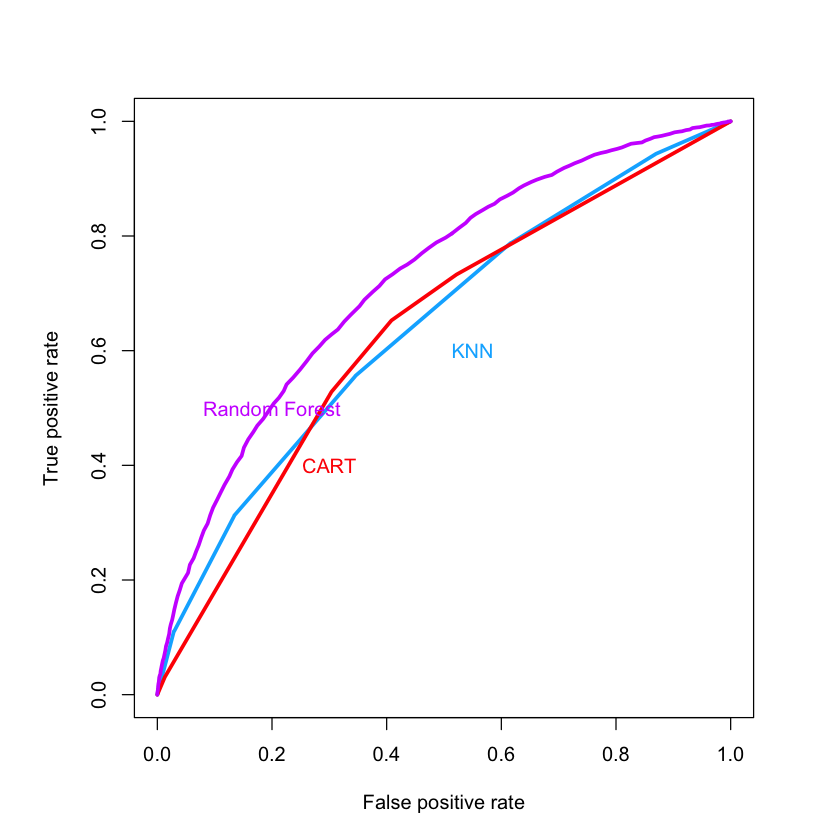

In [66]:
ROCCurve<-par(pty = "s")

plot(performance(prediction(newscla.knn.prob[,2], cla.data[ind==2,]$shares),'tpr','fpr'), col=color.knn, lwd=3)
text(0.55,0.6,"KNN", col=color.knn)

plot(performance(prediction(newscla.cart.prob[,2], cla.data[ind==2,]$shares),'tpr','fpr'), col=color.cart, lwd=3, add=T)
text(0.3,0.4,"CART", col=color.cart)

plot(performance(prediction(newscla.rf.prob[,2], cla.data[ind==2,]$shares),'tpr','fpr'), col=color.rf, lwd=3, add=T)
text(0.2,0.5,"Random Forest", col=color.rf)

### Result: Random Forest is the best model.

### 4.6 Boosting

In [ ]:
newscla <- data.frame(apply(cla.data, 2, function(x) as.numeric(as.character(x)))) #convert into numeric

cv.d1=xgb.cv(data =as.matrix(newscla[ind==1,]), label =newscla[ind==1,]$shares, nrounds = 5000,max_depth = 4, nthread = 2, interaction.depth = 2, nfold = 10, early_stopping_rounds = 10)
cv.d2=xgb.cv(data =as.matrix(newscla[ind==1,]), label =newscla[ind==1,]$shares, nrounds = 5000,max_depth = 5, nthread = 2, interaction.depth = 2, nfold = 10, early_stopping_rounds = 10)
cv.d3=xgb.cv(data =as.matrix(newscla[ind==1,]), label =newscla[ind==1,]$shares, nrounds = 5000,max_depth = 6, nthread = 2, interaction.depth = 2, nfold = 10, early_stopping_rounds = 10)
cv.d4=xgb.cv(data =as.matrix(newscla[ind==1,]), label =newscla[ind==1,]$shares, nrounds = 5000,max_depth = 7, nthread = 2, interaction.depth = 2, nfold = 10, early_stopping_rounds = 10)
cv.d5=xgb.cv(data =as.matrix(newscla[ind==1,]), label =newscla[ind==1,]$shares, nrounds = 5000,max_depth = 8, nthread = 2, interaction.depth = 2, nfold = 10, early_stopping_rounds = 10)

In [64]:
testd1 = as.tibble(cv.d1$evaluation_log$test_rmse_mean)
testd2 = as.tibble(cv.d2$evaluation_log$test_rmse_mean)
testd3 = as.tibble(cv.d3$evaluation_log$test_rmse_mean)
testd4 = as.tibble(cv.d4$evaluation_log$test_rmse_mean)
testd5 = as.tibble(cv.d5$evaluation_log$test_rmse_mean)

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”


In [71]:
# Fitting the model
newscla.boost <- xgboost(as.matrix(newscla[ind==1,]), label = newscla[ind==1,]$shares, max_depth = 4, eta = 0.5,
                 nthread = 2, interaction.depth = 2, nrounds = 450, early_stopping_rounds = 10)

[1]	train-rmse:0.250003 
Will train until train_rmse hasn't improved in 10 rounds.

[2]	train-rmse:0.125006 
[3]	train-rmse:0.062504 
[4]	train-rmse:0.031256 
[5]	train-rmse:0.015628 
[6]	train-rmse:0.007814 
[7]	train-rmse:0.003907 
[8]	train-rmse:0.001955 
[9]	train-rmse:0.000977 
[10]	train-rmse:0.000489 
[11]	train-rmse:0.000244 
[12]	train-rmse:0.000122 
[13]	train-rmse:0.000061 
[14]	train-rmse:0.000031 
[15]	train-rmse:0.000015 
[16]	train-rmse:0.000008 
[17]	train-rmse:0.000004 
[18]	train-rmse:0.000004 
[19]	train-rmse:0.000004 
[20]	train-rmse:0.000004 
[21]	train-rmse:0.000004 
[22]	train-rmse:0.000004 
[23]	train-rmse:0.000004 
[24]	train-rmse:0.000004 
[25]	train-rmse:0.000004 
[26]	train-rmse:0.000004 
[27]	train-rmse:0.000004 
Stopping. Best iteration:
[17]	train-rmse:0.000004



In [82]:
# make prediction
newscla.boost.pred <- predict(newscla.boost, newdata = as.matrix(newscla[ind==2,]))
newscla.boost.prob <- predict(newscla.boost, newdata = as.matrix(newscla[ind==2,]), type="prob")

In [73]:
# confusion matrix of boosting
confusionMatrix(as.factor(round(newscla.boost.pred)), as.factor(newscla[ind==2,]$shares))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3979    0
         1    0 3914
                                     
               Accuracy : 1          
                 95% CI : (0.9995, 1)
    No Information Rate : 0.5041     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5041     
         Detection Rate : 0.5041     
   Detection Prevalence : 0.5041     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

Setting levels: control = 0, case = 1

Setting direction: controls < cases



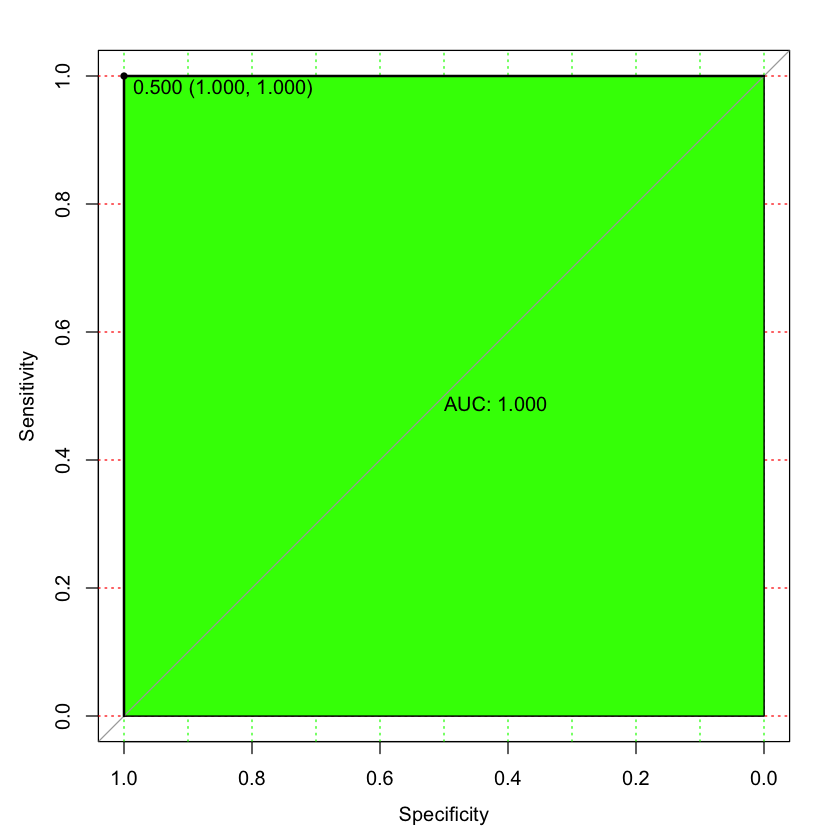

In [78]:
# ROC Curve of boosting
newscla.boost.roc <- roc(newscla[ind==2,]$shares, newscla.boost.prob)
plot(newscla.boost.roc, print.auc=T,
     auc.polygon=T, grid=c(0.1,0.2), grid.col=c("green","red"),
     max.auc.polygon=T, auc.polygon.col=color.boost, print.thres=T)